----
# Doc2Vec & Job Classifier (English Version)

*Author*: Rodrigo Valdelvira Ortigosa

----

<img src= "https://drive.google.com/uc?export=view&id=1hVx_M2Eh8QYsYL2Xk3z2dRqRKSoCypIk" width="80%" height="80%">

## 1. Imports

In [1]:
## General Imports
## =================================================================================================== ##

# arrays and dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# json format
import json

# operating system interfaces
import os

# save model
import joblib
import pickle

# progress bar
from tqdm import tqdm
from time import sleep

# warning ignore
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [18]:
## Gensim import
## =================================================================================================== ##

# Word2Vec & Doc2Vec models
from gensim.models.doc2vec import Word2Vec, TaggedDocument, Doc2Vec 

In [2]:
## Scikitlearn imports
## =================================================================================================== ##

# speed up sklearn
from sklearnex import patch_sklearn
patch_sklearn()

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

# cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# XGBoost library
import xgboost as xgb

from skopt import BayesSearchCV

In [4]:
## Tensorflow imports
## =================================================================================================== ##

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GRU, LSTM, Embedding
from tensorflow.random import set_seed

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import Constant

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6005933321050655996
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8068824419797657079
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


## 2. Load Data

In [6]:
## Experiences Load
## =================================================================================================== ##

experiences = pd.read_csv('database/experiences_category.csv', encoding='utf-8-sig', sep=';')
experiences['job_description_short'] = experiences['job_description_short'].apply(lambda x: eval(x) if not isinstance(x, float) else x)
experiences = experiences[['title', 'job_category', 'job_description_short', 'industry', 'language']] \
    .dropna(subset=['job_description_short', 'job_category'], axis=0) \
    .reset_index(drop=True)

experiences.head(5)

,title,job_category,job_description_short,industry,language
0,Fisioterapeuta,Fisioterapeutas,[fisioterapeuta],Environmental Services,NaN
1,Fisioterapeuta,Fisioterapeutas,[fisioterapeuta],Performing Arts,NaN
2,Fisioterapeuta,Fisioterapeutas,[fisioterapeuta],NaN,NaN
3,Fisioterapeuta,Fisioterapeutas,[fisioterapeuta],Environmental Services,NaN
4,Fisioterapeuta,Fisioterapeutas,[fisioterapeuta],Performing Arts,NaN


Since there are catergory with a low quantity of descriptions, we'll remove those that count with fewer than `4 elements`. This way we can guarantee the existance of at least certain amount of element in both `train`and `test` datasets.

In [7]:
## Category Selection
## =================================================================================================== ##

job_categories = experiences['job_category'].value_counts().to_frame()
jobs_removed = list(job_categories[job_categories['job_category'] < 4].index)

print(f'Number of removed categories: {len(jobs_removed)}')
print(f'Number of remaining categories: {job_categories.shape[0]-len(jobs_removed)}')

Number of removed categories: 6
Number of remaining categories: 110


Taking into account previous action, we proceed to remove elements within dismissed categories

In [8]:
## Job Removing
## =================================================================================================== ##

dataset = experiences.loc[~experiences['job_category'].isin(jobs_removed)]
unknown_data = experiences.loc[experiences['job_category'].isin(jobs_removed)]
   
print(f'Dataset: {dataset.shape[0]} experiences')
print(f'Remaining data: {unknown_data.shape[0]} experiences')

Dataset: 28945 experiences
Remaining data: 9 experiences


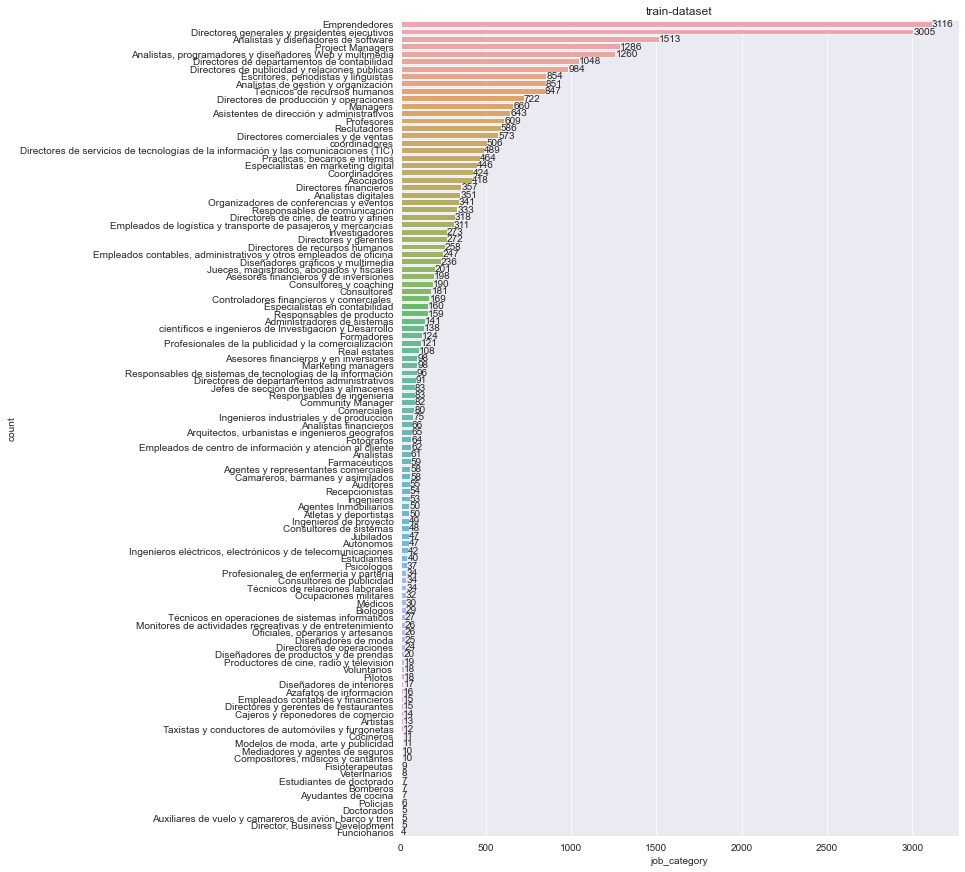

In [9]:
count = dataset['job_category'].value_counts().values
jobs = dataset['job_category'].value_counts().index

plt.figure(figsize=(10, 15))

ax = sns.barplot(y=jobs, x=count, alpha=0.8)
ax.bar_label(ax.containers[0])
plt.title('train-dataset')
plt.xlabel('job_category')
plt.ylabel('count')
plt.xticks( fontsize=10)
plt.yticks(fontsize=10);

## 3. Undersampling

It's really common that our dataset doesn't match our expectation in terms of equilibrium and quantity, instead, the reality is pretty different, the most common lay out consists of an unbalanced dataset as the one we handle. 
The higher the unbalance the higher the bias, fact fully undesirable. To mitigate it, it exsists several technics among the most utilized we can find as follows.
* Oversampling: Increasing the amount of elements of the minority categories (even duplicating same elements).
* Undersampling: Decreasing the amount of elements of the mayority categories.
* SMOTE (Synthetic Minority Oversampling Technique): Technique used for increasing element size by creating new ones from exisitis one using models like KNN. The idea behind, consists of introducing certain noise so that the model receive several times the same pattern, therefore, more probilities of detecting such element.
* Weigth Class: This argument is available in a wide range of models including keras implementations. The idea consists of including a dictionary determining the relationship between the largest class and rest so that the model is able to penalize the majority classes as it's training. 
* Data Augmentation: More utilized in terms of computer vision problems in which sometimes is useful increasing the amount of images by creating variation from original ones such as adding rotations, zoom in, brightness... (it's importate to asure those variation make sense on the dataset context).

This time we'll make use of the undersampling method by decreasing the mayority classes. This exercise will be carried out by deterministic randomness meaning we won't choose the elements that will take part of the final dataset but they will randomly. This implies certain risk as we can dismiss relevant information, however, this is the fastest way to proceed without falling into tedious tasks.

In [10]:
samples = 500
np.random.seed(42)

dataset_short = pd.DataFrame()
for job in jobs:
    category = dataset[dataset['job_category'] == job]
    if category.shape[0] > samples:
        temp_df = category.sample(n=samples)
        dataset_short = pd.concat([dataset_short, temp_df], axis=0)
    else:
        dataset_short = pd.concat([dataset_short, category], axis=0)
        
dataset_short.reset_index(drop=True)

,title,job_category,job_description_short,industry,language
0,Co-founder and buyer of Mine Bag's,Emprendedores,"[co, founder, buyer, mine, bag, personal, proj...",Cosmetics,en
1,CTO & Co-Founder,Emprendedores,"[cto, co, founder, unique, solve, digital, tra...",Internet,en
2,Co-Founder,Emprendedores,"[co, founder]",NaN,NaN
3,Co-Founder and co-CEO,Emprendedores,"[co, founder, ceo, lideré, equipo, desarrollad...",Information Services,es
4,Co-founder & COO,Emprendedores,"[co, founder, coo, start, create, offer, integ...",E-Learning,en
...,...,...,...,...,...
18377,"Project Manager/Director, Business Development","Director, Business Development","[project, manager, director, business, develop...",NaN,en
18378,Civil Servant - Census Officer,Funcionarios,"[civil, servant, census, officer]",Nonprofit Organization Management,NaN
18379,Funcionaria interina,Funcionarios,"[fun, cion, aria]",Public Policy,NaN
18380,Funcionario de carrera en el Ministerio Fomento,Funcionarios,"[carrera, ministerio, fomento]",Government Administration,NaN


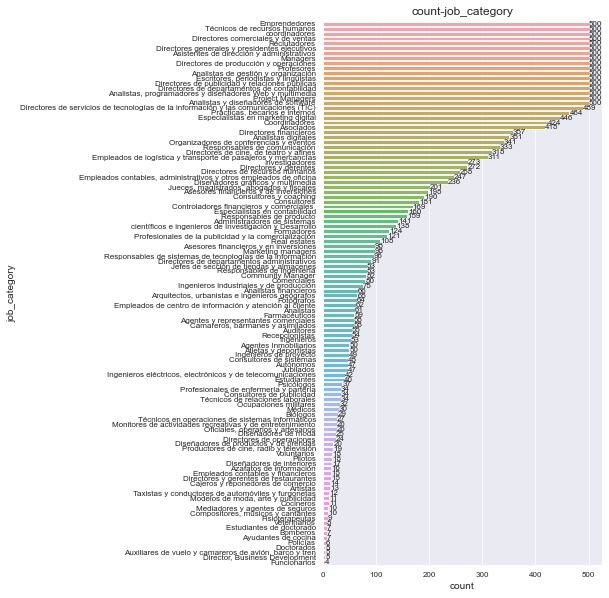

In [11]:
count = dataset_short['job_category'].value_counts().values
jobs = dataset_short['job_category'].value_counts().index

plt.figure(figsize=(5, 10))

ax = sns.barplot(y=jobs, x=count, alpha=0.8)
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('count-job_category')
plt.xlabel('count')
plt.ylabel('job_category')
plt.xticks( fontsize=8)
plt.yticks(fontsize=8);

## 4. Dataset

The dataset will be splitted into two as usual for this kind of problematic (train/ test), being carefull of stratifying by `job_category`, so that we'll get proporcional amount of elements for both datasets. 

In [12]:
## train/test 80/20
## =================================================================================================== ##

# train/test split 
train_df, test_df = train_test_split(dataset_short, test_size=0.2, random_state=42, stratify=dataset_short['job_category'])
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

The targets, this case `job_category` will be defined by number coding. 

In [13]:
labeler = LabelEncoder()

train_df['target'] = labeler.fit_transform(train_df['job_category'])
test_df['target']  = labeler.transform(test_df['job_category'])

In [14]:
indexes = [index for index in range(len(labeler.classes_))]

index_category = dict(zip(indexes, labeler.classes_))
list(index_category.items())[0:20]

[(0, 'Administradores de sistemas'),
 (1, 'Agentes Inmobiliarios'),
 (2, 'Agentes y representantes comerciales'),
 (3, 'Analistas'),
 (4, 'Analistas de gestión y organización'),
 (5, 'Analistas digitales'),
 (6, 'Analistas financieros'),
 (7, 'Analistas y diseñadores de software'),
 (8, 'Analistas, programadores y diseñadores Web y multimedia'),
 (9, 'Arquitectos, urbanistas e ingenieros geógrafos'),
 (10, 'Artistas'),
 (11, 'Asesores financieros y de inversiones'),
 (12, 'Asesores financieros y en inversiones'),
 (13, 'Asistentes de dirección y administrativos'),
 (14, 'Asociados'),
 (15, 'Atletas y deportistas'),
 (16, 'Auditores'),
 (17, 'Autónomos'),
 (18, 'Auxiliares de vuelo y camareros de avión, barco y tren'),
 (19, 'Ayudantes de cocina')]

In [16]:
## Exporting index_category for further application .json
## =============================================================================

with open('database/index_category.json', 'w',  encoding='utf-8') as f:
    json.dump(index_category, f, ensure_ascii=False, indent=4)

In [17]:
print(f'train size: {train_df.shape[0]}')
print(f'test size: {test_df.shape[0]}')

train size: 14705
test size: 3677


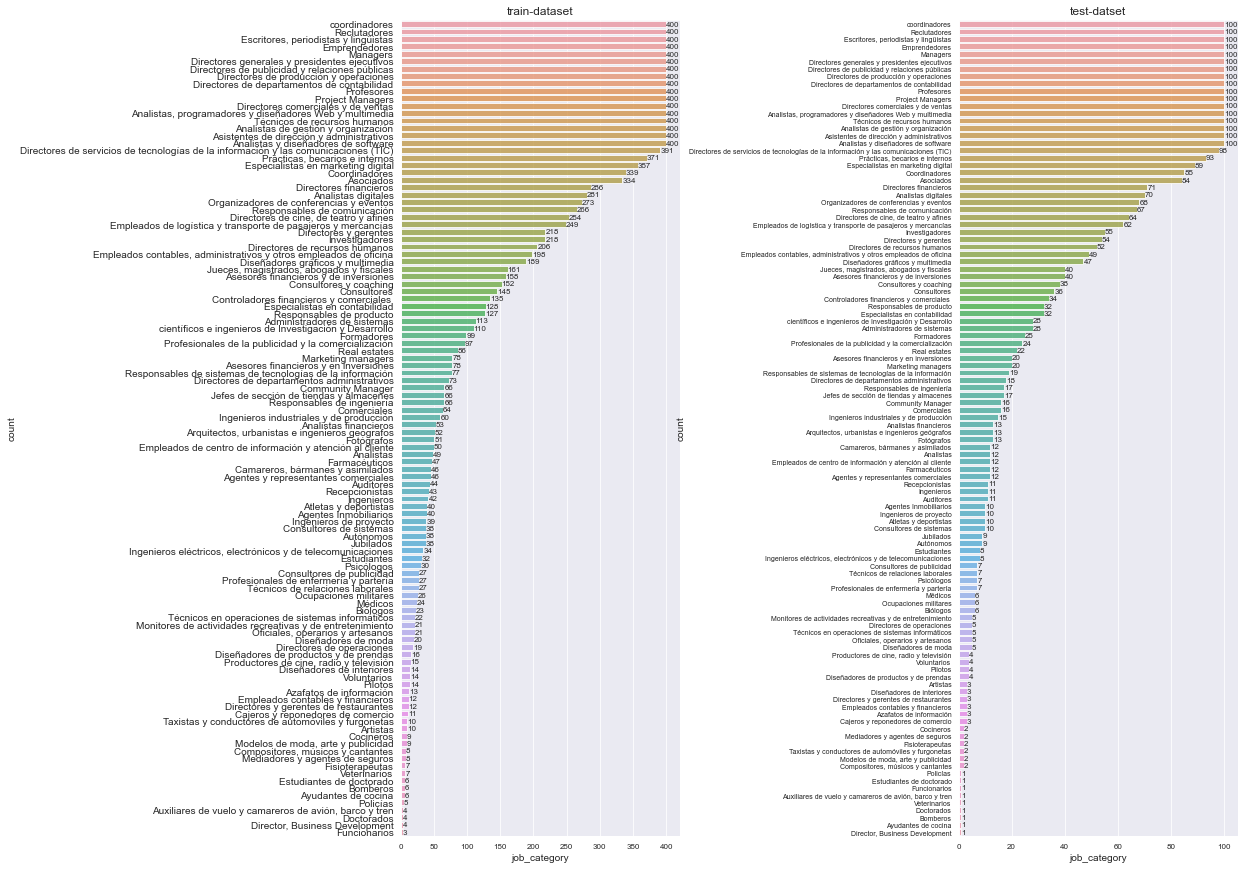

In [18]:
train_cts = train_df['job_category'] \
    .sort_values(ascending=False) \
    .value_counts() \
    .index
train_values = train_df['job_category'] \
    .sort_values(ascending=False) \
    .value_counts() \
    .values

test_cts = test_df['job_category'] \
    .sort_values(ascending=False) \
    .value_counts() \
    .index
test_values = test_df['job_category'] \
    .sort_values(ascending=False) \
    .value_counts() \
    .values

plt.figure(figsize=(15, 15))

plt.subplot(121)
ax = sns.barplot(x=train_values, y=train_cts, alpha=0.8)
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('train-dataset')
plt.xlabel('job_category')
plt.ylabel('count')
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)

plt.subplot(122)
ax = sns.barplot(x=test_values, y=test_cts, alpha=0.8)
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('test-datset')
plt.xlabel('job_category')
plt.ylabel('count')
plt.xticks(fontsize=8)
plt.yticks(fontsize=7)

plt.subplots_adjust(wspace = 1);

## 5. Text Coding

To reach a good performance, our model must be able to learn the context of the text it will be fed with. To do so, there are several techniques focused on this task. We'll use some of the most popular ones.

* Tf-IDF
* Word2Vec
* Doc2Vec

### 5.1 tf-idf

tf-idf is based on the idea that the context of a text is given by the mos common word in it, howerver, instead of using a simple BOW (Bag of Words) model, this technique will also take into consideration the relative frequence of each word on each single document and on the documen set. Thus, the most common words will be penalized in favor of less frequent terms that might be more releavant on a class context.

In [19]:
## Word Count
## =================================================================================================== ##
tfidf_vectorizer=TfidfVectorizer(use_idf=True)

train_df_join = train_df['job_description_short'].str.join(sep=' ') 
test_df_join  = test_df['job_description_short'].str.join(sep=' ')

In [20]:
## Text transformatiion
## =================================================================================================== ##

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df_join)
X_test_tfidf  = tfidf_vectorizer.transform(test_df_join)

In [52]:
## Targets will be common for all models
## =================================================================================================== ##

y_train = train_df['target']
y_test  = test_df['target']

### 5.2 Word2Vec

`Word2Vec` is based on the premise of dimensional reduction, one of the main problems dragged by simplistic models like `BOW` or `tf-idf` which have to deal with large matrix systems derived from the single tokenizing, the resulting array for each document is compounded of as many columns as words in dataset including the suitable coeffiecient in each place. 

On the other hand, `Word2Vec` promise to find a compromised between efficiency and size, representing each word with a `n-dimensional vector`. Besides, this technique is capable of detecting semantic correlation among similar meaning words. Hence, each document will be represented by a matrix compounded of as many rows as words in document and as many columns as dimensions are chosen (common dimensions 50, 100, 300).  

In [16]:
embedding_path = 'models/word2vec/'
embedding_dim = 50

In [21]:
## Model definition
## =================================================================================================== ##

text_emb =  Word2Vec(
                sentences   = train_df['job_description_short'],
                vector_size = embedding_dim,
                window      = 2,
                min_count   = 1,
                workers     = 4,
                epochs      = 100
)
word_vecs = text_emb.wv

word_vecs.save_word2vec_format(embedding_path + 'custom_w2v.txt', binary=False)
word_vecs.save(embedding_path + 'word2vec.model')

In [23]:
word_vecs = word_vecs.load(embedding_path + 'word2vec.model')

In [24]:
print (f'input vocabulary size: {len(word_vecs.index_to_key)} words \nembedding dimension: {word_vecs.vector_size}')

input vocabulary size: 10222 words 
embedding dimension: 50


In [28]:
word_vecs.most_similar('manage', topn=10)

[('responsible', 0.8631147146224976),
 ('management', 0.8227859735488892),
 ('lead', 0.8086273670196533),
 ('develop', 0.8006348609924316),
 ('include', 0.7973645329475403),
 ('coordinate', 0.7971449494361877),
 ('support', 0.7682666182518005),
 ('team', 0.7528480887413025),
 ('work', 0.750880241394043),
 ('multiple', 0.7400889992713928)]

In [37]:
word_vecs.most_similar('gestión', topn=10)

[('población', 0.6746813654899597),
 ('búsqueda', 0.6477763652801514),
 ('lazo', 0.6320410370826721),
 ('supervisión', 0.6267547607421875),
 ('lidero', 0.6184195876121521),
 ('plataforma', 0.6111401319503784),
 ('empleado', 0.6092893481254578),
 ('herramienta', 0.6062042117118835),
 ('evolutivo', 0.5991312265396118),
 ('tradicional', 0.5966110229492188)]

In [40]:
## two-dimensional representation by menas of t-sne model
## =================================================================================================== ##

tsne = TSNE(
    n_components = 2,
    verbose      = 1,
    random_state = 42)

tsne_2d = tsne.fit_transform(word_vecs.vectors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10222 samples in 0.012s...
[t-SNE] Computed neighbors for 10222 samples in 0.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10222
[t-SNE] Computed conditional probabilities for sample 2000 / 10222
[t-SNE] Computed conditional probabilities for sample 3000 / 10222
[t-SNE] Computed conditional probabilities for sample 4000 / 10222
[t-SNE] Computed conditional probabilities for sample 5000 / 10222
[t-SNE] Computed conditional probabilities for sample 6000 / 10222
[t-SNE] Computed conditional probabilities for sample 7000 / 10222
[t-SNE] Computed conditional probabilities for sample 8000 / 10222
[t-SNE] Computed conditional probabilities for sample 9000 / 10222
[t-SNE] Computed conditional probabilities for sample 10000 / 10222
[t-SNE] Computed conditional probabilities for sample 10222 / 10222
[t-SNE] Mean sigma: 0.715807
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.108902
[t-SNE] KL 

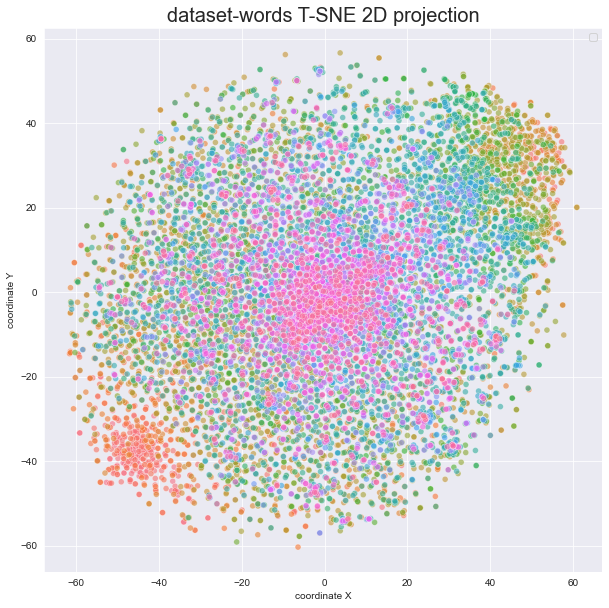

In [41]:
## two-dimensional representaiton plotting
## =================================================================================================== ##

plt.figure(figsize=(10, 10))
sns.scatterplot(
        x     = tsne_2d[:,0],
        y     = tsne_2d[:,1],
        hue   = word_vecs.index_to_key,
        alpha = 0.6
)
plt.legend('')
plt.title('dataset-words T-SNE 2D projection', fontsize=20)
plt.xlabel('coordinate X', fontsize=10)
plt.ylabel('coordinate Y', fontsize=10);

In [42]:
## Embedding indexes
## =================================================================================================== ##

def embeddings_index(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print(f'Found: {len(embeddings_index)} word vectors')
    return embeddings_index

In [43]:
## Embedding Matrix
## =================================================================================================== ##

def embedding_matrix (num_tokens, word_index, embedding_dim, embeddings_index):
    hits = 1
    misses = []
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and len(embedding_vector) >0:
              # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses.append(word)
    print(f'Converted: {hits} words\nMisses: {len(misses)} words')
    return embedding_matrix, misses

In [44]:
## Train dataset tokenizing
## =============================================================================

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['job_description_short'])

X_train_vocab_size = len(tokenizer.word_index) + 1

# vocab_size
print(f'vocabulary size: {X_train_vocab_size} words')

vocabulary size: 10223 words


In [45]:
## input/target index_word dictionary
## =============================================================================

word_index = dict(zip(tokenizer.word_index.keys(), tokenizer.word_index.values()))

In [46]:
## Exporting word_index for further application .json
## =============================================================================

with open('database/word_index.json', 'w',  encoding='utf-8') as f:
    json.dump(word_index, f, ensure_ascii=False, indent=4)

In [47]:
list(word_index.items())[0:20]

[('manager', 1),
 ('marketing', 2),
 ('project', 3),
 ('business', 4),
 ('team', 5),
 ('manage', 6),
 ('product', 7),
 ('development', 8),
 ('management', 9),
 ('director', 10),
 ('work', 11),
 ('company', 12),
 ('include', 13),
 ('sale', 14),
 ('develop', 15),
 ('web', 16),
 ('client', 17),
 ('service', 18),
 ('design', 19),
 ('lead', 20)]

In [48]:
## from token to numbers train dataset
## =============================================================================

X_train_num = tokenizer.texts_to_sequences(train_df['job_description_short'])
X_test_num =  tokenizer.texts_to_sequences(test_df['job_description_short'])

In [53]:
## train/test dataset
## =============================================================================

BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(X_train_num), y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(X_test_num), y_test)).batch(BATCH_SIZE)

In [51]:
## embedding matrix input
## =============================================================================

embeddings_index = embeddings_index(embeddings_path + 'custom_w2v.txt')
embedding_matrix, misses = embedding_matrix(X_train_vocab_size, tokenizer.word_index, embedding_dim, embeddings_index)

Found: 10207 word vectors
Converted: 10195 words
Misses: 28 words


### 5.3 Doc2Vec

Word2Vec is based on `Doc2Vec` idea, the embedding as dimensional reducer by representing an entire document with a `n-dimensional vector`.

In [73]:
## Tagging of documents
## =============================================================================

train_tagged = train_df.apply(lambda row: TaggedDocument(row['job_description_short'], row['job_category']), axis=1).tolist()
test_tagged  =  test_df.apply(lambda row: TaggedDocument(row['job_description_short'], row['job_category']), axis=1).tolist()

In [74]:
## Model definition
## =============================================================================

model = Doc2Vec(
    vector_size = 50,
    window      = 2, 
    alpha       = .025, 
    min_alpha   = 0.00025, 
    min_count   = 1, 
    dm          = 1, 
    workers     = -1,
    epochs      = 100
)
model.build_vocab(train_tagged)
model.save('models/doc2vec/doc2vec.model')

In [75]:
## Embedding vectors
## =============================================================================

X_train_d2v = np.array([model.infer_vector(train_tagged[i][0]) for i in range(len(train_tagged))])
X_test_d2v = np.array([model.infer_vector(test_tagged[i][0]) for i in range(len(test_tagged))])

In [56]:
## two-dimensional representation by menas of t-sne model
## =================================================================================================== ##

tsne = TSNE(
    n_components = 2,
    verbose      = 1,
    random_state = 42)

tsne_2d = tsne.fit_transform(X_train_d2v)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10360 samples in 0.001s...
[t-SNE] Computed neighbors for 10360 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10360
[t-SNE] Computed conditional probabilities for sample 2000 / 10360
[t-SNE] Computed conditional probabilities for sample 3000 / 10360
[t-SNE] Computed conditional probabilities for sample 4000 / 10360
[t-SNE] Computed conditional probabilities for sample 5000 / 10360
[t-SNE] Computed conditional probabilities for sample 6000 / 10360
[t-SNE] Computed conditional probabilities for sample 7000 / 10360
[t-SNE] Computed conditional probabilities for sample 8000 / 10360
[t-SNE] Computed conditional probabilities for sample 9000 / 10360
[t-SNE] Computed conditional probabilities for sample 10000 / 10360
[t-SNE] Computed conditional probabilities for sample 10360 / 10360
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.375687
[t-SNE] KL 

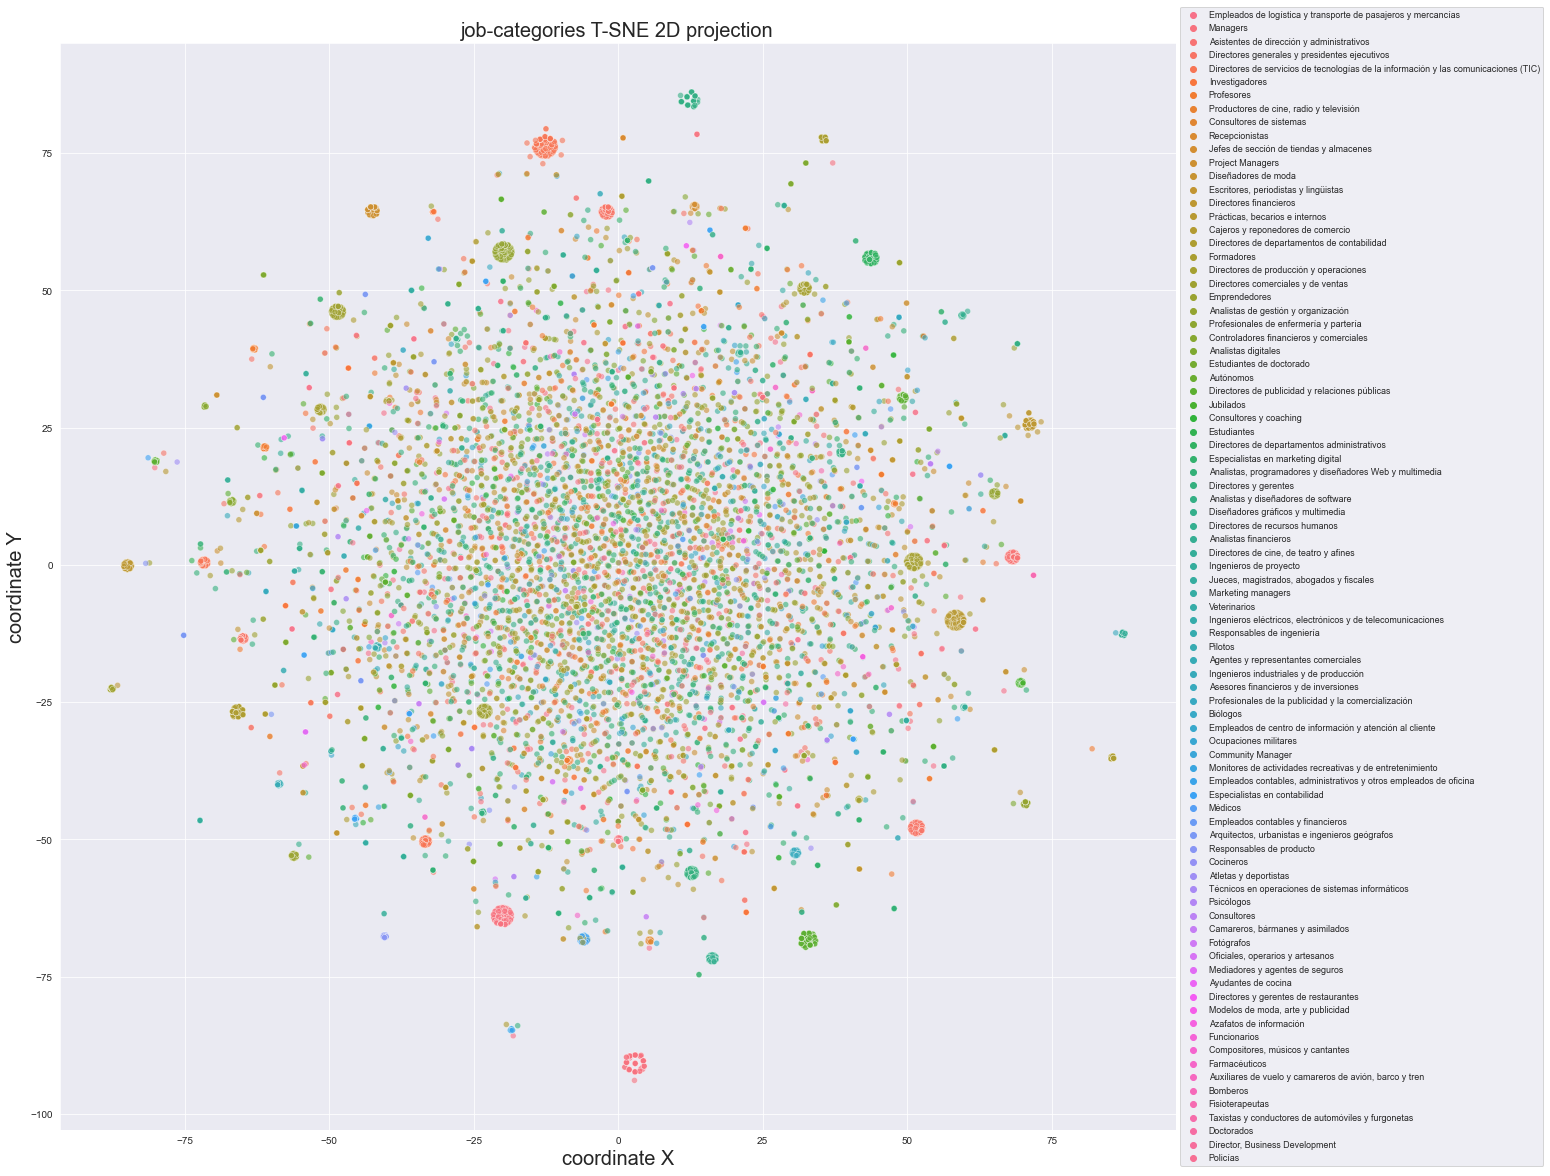

In [57]:
## two-dimensional representaiton plotting
## =================================================================================================== ##

plt.figure(figsize=(20, 20))
sns.scatterplot(
        x     = tsne_2d[:,0],
        y     = tsne_2d[:,1],
        hue   = train_df['job_category'],
        alpha = 0.6
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8.9)
plt.title('job-categories T-SNE 2D projection', fontsize=20)
plt.xlabel('coordinate X', fontsize=20)
plt.ylabel('coordinate Y', fontsize=20);

## 6. Models

### 6.1. Regular Machine Learning Models

For the first place, we'll define some common models widely used in ML world from basic `Logist Regressors` up to `Gradient Boosting Trees`.
The studied models are as follows:

* Logistic Regression
* Ridge Classifier
* k-nearest neighbors
* Bagging Trees
* Random Forest

It's been proposesd a parameter grid for all classifiers in the way we can reach a good performance by applying `GrdiSearchCV` technique provided by `Scikitlearn`. The reference metric is `Accuracy` and `F1` is also monitorized .

In [76]:
## Classifiers
## =============================================================================

classifiers = ['LR_Clf', 'Ridge_Clf', 'KNN_Clf', 'Bagg_Clf', 'RF_Clf']

## Parameter Grids
## =============================================================================

parameters = {}

# Logistic Regression
parameters['LR_Clf'] =  {
        'clf': LogisticRegression(), 
        'params': {
            'solver':  ['newton-cg'],
            'penalty': ['l2'],
            'C':       [100, 10, 1.0, 0.1, 0.01]
        }
    }

# Ridge Classifier
parameters['Ridge_Clf'] = {
        'clf': RidgeClassifier(), 
        'params': {
            'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        }
    }

# KNN Classifier
parameters['KNN_Clf'] = {
        'clf': KNeighborsClassifier(),
        'params': {
            'n_neighbors': range(1, 21, 2),
            'weights':     ['uniform', 'distance'],
            'metric':      ['euclidean', 'manhattan', 'minkowski']
            }
        }

# Bagging Classifier
parameters['Bagg_Clf'] = {
        'clf': BaggingClassifier(),
        'params': {
            'n_estimators': [10, 100, 1000]
            }
        }

# Random Forest Classifier
parameters['RF_Clf'] = {
        'clf': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 100, 1000],
            'max_features': ['sqrt', 'log2']
            }
        }

In [77]:
## Training Function
## =============================================================================

def classifiers_training(X, y, path):

    results=pd.DataFrame()
    params={}

    pbar = tqdm(total=len(classifiers))
    for classifier in classifiers:
        sleep(0.5)

        # model definition
        grid = GridSearchCV(
                estimator  = parameters[classifier]['clf'],
                param_grid = parameters[classifier]['params'],
                scoring    = ['accuracy', 'f1_weighted'],
                cv         = 3, 
                refit      = 'accuracy',
                verbose    = 0,
                return_train_score = True
               )

        # model training
        print(f'{classifier}: processing...' )
        clf_grid = grid.fit(X, y);

        # save model
        filename_model = os.path.join(path, f'{classifier}.sav')
        pickle.dump(clf_grid.best_estimator_, open(filename_model, 'wb'))

        # results
        temp_df = pd.DataFrame(clf_grid.cv_results_)
        temp_df = temp_df.filter(regex = '^mean_t') \
            .sort_values('mean_test_accuracy', ascending = False) \
            .round(3) \
            .iloc[0] \
            .to_frame() \
            .set_axis([classifier], axis=1) \
            .T
        results = pd.concat([results, temp_df], axis=0)
        params[classifier] = clf_grid.best_params_

        pbar.set_description(f'{classifier} => train_acc: {temp_df.iloc[0].mean_train_accuracy} - test_acc: {temp_df.iloc[0].mean_test_accuracy} - saved as: {filename_model}')
        pbar.update(1)

    # save best parameters as .json
    filename_params = os.path.join(path, 'classifiers_params.json')
    with open(filename_params, 'w',  encoding='utf-8') as f:
        json.dump(params, f, ensure_ascii=False, indent=4)
    print(f'best parameters saved as: {filename_params}')

    # save best results as np array
    np.save(path + 'results.npy', results)
    print(f'best results saved as: {path}results.npy')

    return results.sort_values('mean_test_accuracy', ascending = False)

## 7. Calculations

### 7.1 tf-idf: ML Models

The models defined on secction 6 will be applied on the `tf-idf` transformation.

In [83]:
## tf-idf & ML Models
## =============================================================================

classifiers_training(X_train_tfidf, y_train, 'models/tf-idf/')

  0%|          | 0/5 [00:00<?, ?it/s]

LR_Clf: processing...


LR_Clf => train_acc: 0.999 - test_acc: 0.878 - saved as: models/tf-idf/LR_Clf.sav:  20%|██        | 1/5 [03:34<14:17, 214.38s/it]

Ridge_Clf: processing...


Ridge_Clf => train_acc: 0.971 - test_acc: 0.842 - saved as: models/tf-idf/Ridge_Clf.sav:  40%|████      | 2/5 [04:45<06:29, 129.83s/it]

KNN_Clf: processing...


KNN_Clf => train_acc: 0.999 - test_acc: 0.821 - saved as: models/tf-idf/KNN_Clf.sav:  60%|██████    | 3/5 [09:21<06:33, 196.74s/it]    

Bagg_Clf: processing...


Bagg_Clf => train_acc: 0.999 - test_acc: 0.882 - saved as: models/tf-idf/Bagg_Clf.sav:  80%|████████  | 4/5 [43:32<15:28, 928.92s/it]

RF_Clf: processing...


RF_Clf => train_acc: 0.999 - test_acc: 0.909 - saved as: models/tf-idf/RF_Clf.sav: 100%|██████████| 5/5 [55:05<00:00, 661.14s/it]    


best parameters saved as: models/tf-idf/classifiers_params.json
best results saved as: models/tf-idf/results.npy


,mean_test_accuracy,mean_train_accuracy,mean_test_f1_weighted,mean_train_f1_weighted
RF_Clf,0.909,0.999,0.906,0.999
Bagg_Clf,0.882,0.999,0.880,0.999
LR_Clf,0.878,0.999,0.876,0.999
Ridge_Clf,0.842,0.971,0.834,0.969
KNN_Clf,0.821,0.999,0.818,0.999


### 7.2 tf-idf: XGBoost Classifier

In [79]:
# obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train_tfidf , y_train.values.ravel())

# extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

# default parameters have to be wrapped in lists - even single values - so RandomizedSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

In [80]:
# setting grid of selected parameters for iteration
param_grid = {'gamma':         [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth':     [5,6,7,8,9,10,11,12,13,14],
              'n_estimators':  [50,65,80,100,115,130,150],
              'reg_alpha':     [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda':    [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

# No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

# unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

# providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = RandomizedSearchCV(estimator       = xgbc,
                    param_distributions  = param_grid,
                    n_iter               = gcvj,
                    scoring              = 'accuracy',
                    cv                   = 3,
                    return_train_score   = True,
                    refit                = True,
                    verbose              = 3
                   )
clf_bay = clf.fit(X_train_tfidf , y_train.values.ravel())

Fitting 3 folds for each of 68 candidates, totalling 204 fits
[CV 1/3] END gamma=200, learning_rate=0.4, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=6.4;, score=(train=0.600, test=0.587) total time= 1.6min
[CV 2/3] END gamma=200, learning_rate=0.4, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=6.4;, score=(train=0.627, test=0.630) total time= 1.7min
[CV 3/3] END gamma=200, learning_rate=0.4, max_depth=12, n_estimators=130, reg_alpha=0.8, reg_lambda=6.4;, score=(train=0.606, test=0.579) total time= 1.6min
[CV 1/3] END gamma=51.2, learning_rate=0.300000012, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.8;, score=(train=0.805, test=0.776) total time=  38.9s
[CV 2/3] END gamma=51.2, learning_rate=0.300000012, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.8;, score=(train=0.795, test=0.784) total time=  41.1s
[CV 3/3] END gamma=51.2, learning_rate=0.300000012, max_depth=8, n_estimators=65, reg_alpha=0.2, reg_lambda=0.8;, score=(train=0.812, 

In [81]:
filename_model = 'models/tf-idf/xgb.sav'
joblib.dump(clf_bay.best_estimator_, filename_model)

['models/tf-idf/xgb.sav']

In [82]:
xgb_results = pd.DataFrame(clf_bay.cv_results_) \
    .filter(regex = '^mean_t') \
    .sort_values('mean_test_score', ascending = False) \
    .round(3) \
    .head(5)
xgb_results

,mean_test_score,mean_train_score
31,0.899,0.984
16,0.898,0.967
42,0.895,0.986
6,0.893,0.962
60,0.891,0.971


In [83]:
# save results as np array
np.save('models/tf-idf/xgb_results.npy', xgb_results)

In [84]:
# best hyperparameters
# ==============================================================================

print(clf_bay.best_params_, ":", round(clf_bay.best_score_, 3), clf_bay.scoring)

{'reg_lambda': 0.8, 'reg_alpha': 0.2, 'n_estimators': 115, 'max_depth': 14, 'learning_rate': 0.2, 'gamma': 0.4} : 0.899 accuracy


### 7.3 Doc2Vec: ML Models

The models defined on secction 6 will be applied on the `Doc2Vec` transformation.

In [78]:
classifiers_training(X_train_d2v, y_train, 'models/doc2vec/')

  0%|          | 0/5 [00:00<?, ?it/s]

LR_Clf: processing...


LR_Clf => train_acc: 0.28 - test_acc: 0.266 - saved as: models/doc2vec/LR_Clf.sav:  20%|██        | 1/5 [00:29<01:58, 29.51s/it]

Ridge_Clf: processing...


Ridge_Clf => train_acc: 0.269 - test_acc: 0.257 - saved as: models/doc2vec/Ridge_Clf.sav:  40%|████      | 2/5 [00:30<00:38, 12.89s/it]

KNN_Clf: processing...


KNN_Clf => train_acc: 0.999 - test_acc: 0.492 - saved as: models/doc2vec/KNN_Clf.sav:  60%|██████    | 3/5 [03:29<02:57, 88.59s/it]    

Bagg_Clf: processing...


Bagg_Clf => train_acc: 0.999 - test_acc: 0.496 - saved as: models/doc2vec/Bagg_Clf.sav:  80%|████████  | 4/5 [1:45:49<41:17, 2477.47s/it]

RF_Clf: processing...


MemoryError: 

## 8. Neural Networks

After checking the efficiency of regular classification models, it is the turn for `Neural Networks`. This time, we'll consider `Word2Vec` transformation, the pretrained embedding matrix will be added as first layer in the models.

### 8.1 DNN (Dense Neural Network)

In [37]:
path = 'models/word2vec/'

In [38]:
## Model Architecture
## ======================================================

dnn = Sequential([
            Dense(16, activation  ='relu', input_shape=(X_train_tfidf.shape[1],)),
            BatchNormalization(),
            Dropout(rate=0.2),
            Dense(32),
            BatchNormalization(),
            Dense(len(jobs), activation='softmax')
              ])
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                163104    
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 110)               3

In [39]:
## Model Compiling
## ======================================================

dnn.compile(loss='sparse_categorical_crossentropy',
              optimizer= 'RMSprop',
              metrics=['accuracy'])

In [40]:
## Model Fit
## ======================================================

clear_session()
np.random.seed(42)
set_seed(42)

checkpoint_cb = ModelCheckpoint(path + 'dnn.h5', save_best_only=True)
history_dnn = dnn.fit(X_train_tfidf.todense(),
                  y_train, 
                  epochs=60,
                  batch_size=32,
                  validation_data=(X_test_tfidf.todense(), y_test),
                  callbacks=[checkpoint_cb])

# hisotry save 
np.save(path + 'history_dnn.npy', history_dnn.history)

Epoch 1/60
460/460 [==============================] - 5s 8ms/step - loss: 2.8962 - accuracy: 0.4114 - val_loss: 2.8650 - val_accuracy: 0.6190
Epoch 2/60
460/460 [==============================] - 3s 7ms/step - loss: 1.4629 - accuracy: 0.6744 - val_loss: 1.2109 - val_accuracy: 0.7202
Epoch 3/60
460/460 [==============================] - 3s 8ms/step - loss: 1.0295 - accuracy: 0.7596 - val_loss: 1.0547 - val_accuracy: 0.7444
Epoch 4/60
460/460 [==============================] - 3s 7ms/step - loss: 0.8040 - accuracy: 0.8122 - val_loss: 1.0116 - val_accuracy: 0.7658
Epoch 5/60
460/460 [==============================] - 3s 7ms/step - loss: 0.6746 - accuracy: 0.8413 - val_loss: 0.9741 - val_accuracy: 0.7694
Epoch 6/60
460/460 [==============================] - 3s 7ms/step - loss: 0.5841 - accuracy: 0.8634 - val_loss: 0.9721 - val_accuracy: 0.7658
Epoch 7/60
460/460 [==============================] - 3s 7ms/step - loss: 0.5355 - accuracy: 0.8730 - val_loss: 0.9613 - val_accuracy: 0.7656
Epoch 

In [41]:
## Model Load
## ======================================================

dnn     = load_model(path + 'dnn.h5')
history = np.load(path + 'history_dnn.npy', allow_pickle='True').item()

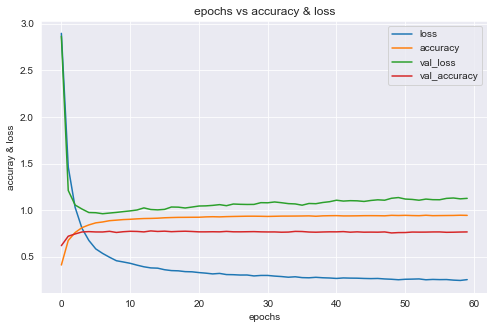

In [42]:
## Plotting
## ======================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
plt.grid(True)

In [43]:
## Model Evaluation
## ======================================================

result_train = dnn.evaluate(X_train_tfidf.todense(), y_train)
result_test  = dnn.evaluate(X_test_tfidf.toarray(), y_test)

115/115 [==============================] - 0s 4ms/step - loss: 0.9613 - accuracy: 0.7656


### 8.2 RNN (Recurrent Neural Networks)

#### 8.2.1 RNN 1

In [44]:
## Model Architecture
## ======================================================

rnn = Sequential([
    Embedding(input_dim=X_train_vocab_size, 
                  output_dim=embedding_dim,
                  embeddings_initializer=Constant(embedding_matrix),
                  trainable=False,
                  ),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.2),
    Dense(len(jobs), activation='softmax')
])

In [45]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          511150    
                                                                 
 lstm (LSTM)                 (None, None, 128)         91648     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 110)               14190     
                                                                 
Total params: 748,572
Trainable params: 237,422
Non-trainable params: 511,150
_________________________________________________________________


In [46]:
## Model Compiling
## ======================================================

rnn.compile(loss='sparse_categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [47]:
## Model Fit
## ======================================================

clear_session()
np.random.seed(42)
set_seed(42)

checkpoint_cb = ModelCheckpoint(path + 'rnn.h5', save_best_only=True)
history_rnn = rnn.fit(train_ds, 
                  epochs=60,
                  validation_data=test_ds,
                  callbacks=[checkpoint_cb])

# save history
np.save(path + 'history_rnn.npy', history_rnn.history)

Epoch 1/60
460/460 [==============================] - 17s 30ms/step - loss: 2.9975 - accuracy: 0.3304 - val_loss: 2.0827 - val_accuracy: 0.5151
Epoch 2/60
460/460 [==============================] - 12s 26ms/step - loss: 1.9459 - accuracy: 0.5466 - val_loss: 1.5168 - val_accuracy: 0.6620
Epoch 3/60
460/460 [==============================] - 11s 23ms/step - loss: 1.4400 - accuracy: 0.6704 - val_loss: 1.2286 - val_accuracy: 0.7264
Epoch 4/60
460/460 [==============================] - 11s 24ms/step - loss: 1.0313 - accuracy: 0.7634 - val_loss: 0.8481 - val_accuracy: 0.8175
Epoch 5/60
460/460 [==============================] - 11s 24ms/step - loss: 0.8044 - accuracy: 0.8157 - val_loss: 0.7147 - val_accuracy: 0.8355
Epoch 6/60
460/460 [==============================] - 11s 25ms/step - loss: 0.6484 - accuracy: 0.8464 - val_loss: 0.5846 - val_accuracy: 0.8646
Epoch 7/60
460/460 [==============================] - 11s 25ms/step - loss: 0.5228 - accuracy: 0.8755 - val_loss: 0.4982 - val_accuracy:

In [48]:
## model load
## ======================================================

rnn         = load_model(path + 'rnn.h5')
history_rnn = np.load(path + 'history_rnn.npy', allow_pickle='TRUE').item()

In [49]:
## model evaluation
## ======================================================

result_train = rnn.evaluate(train_ds)
result_test  = rnn.evaluate(test_ds)

115/115 [==============================] - 1s 9ms/step - loss: 0.2948 - accuracy: 0.9442


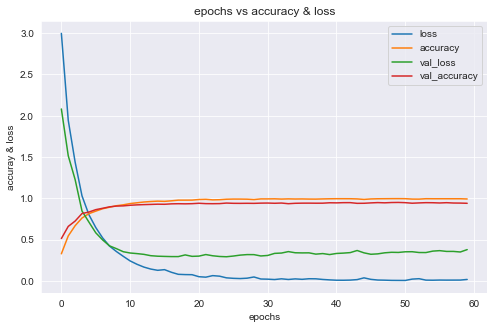

In [50]:
## Plotting
## ======================================================

pd.DataFrame(history_rnn).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
plt.grid(True)
plt.savefig('learning_curves_dnn');

In [51]:
y_pred_test = np.argmax(rnn.predict(tf.ragged.constant(X_test_num)), axis=1)
np.array(labeler.classes_)[y_pred_test]

array(['Asociados', 'Asesores financieros y en inversiones', 'Managers',
       ..., 'Técnicos de recursos humanos', 'Investigadores',
       'Directores de departamentos administrativos'], dtype=object)

In [52]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
rnn_report = classification_report(y_test, y_pred_test, target_names=labeler.classes_, output_dict=True)
rnn_report_df = pd.DataFrame(rnn_report) \
    .transpose() \
    .round(3)

rnn_report_df

,precision,recall,f1-score,support
Administradores de sistemas,0.771,0.964,0.857,28.000
Agentes Inmobiliarios,1.000,1.000,1.000,10.000
Agentes y representantes comerciales,1.000,1.000,1.000,12.000
Analistas,0.923,1.000,0.960,12.000
Analistas de gestión y organización,0.980,0.970,0.975,100.000
Analistas digitales,0.932,0.971,0.951,70.000
Analistas financieros,1.000,1.000,1.000,13.000
Analistas y diseñadores de software,0.980,0.980,0.980,100.000
"Analistas, programadores y diseñadores Web y multimedia",0.920,0.920,0.920,100.000
"Arquitectos, urbanistas e ingenieros geógrafos",0.929,1.000,0.963,13.000


#### 8.2.2 RNN 2 

In [53]:
## Model Definition
## ======================================================

rnn_2 = Sequential([
    Embedding(input_dim                  = X_train_vocab_size, 
                  output_dim             = embedding_dim,
                  embeddings_initializer = Constant(embedding_matrix),
                  trainable              = False,
                  ),
    GRU(16, return_sequences=True),
    GRU(16),
    Dropout(0.2),
    Dense(len(jobs), activation='softmax')
])
rnn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          511150    
                                                                 
 gru (GRU)                   (None, None, 16)          3264      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 110)               1870      
                                                                 
Total params: 517,916
Trainable params: 6,766
Non-trainable params: 511,150
_________________________________________________________________


In [54]:
## model compiling
## ======================================================

rnn_2.compile(loss='sparse_categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [55]:
## Model Fit
## ======================================================

clear_session()
np.random.seed(42)
set_seed(42)

checkpoint_cb = ModelCheckpoint(path + 'rnn_2.h5', save_best_only=True)
history_rnn_2 = rnn_2.fit(train_ds, 
                  epochs=60,
                  validation_data=test_ds,
                  callbacks=[checkpoint_cb])

# hisotry save 
np.save(path + 'history_rnn_2.npy', history_rnn_2.history)

Epoch 1/60
460/460 [==============================] - 14s 26ms/step - loss: 4.2065 - accuracy: 0.0524 - val_loss: 3.9280 - val_accuracy: 0.1265
Epoch 2/60
460/460 [==============================] - 10s 22ms/step - loss: 3.6908 - accuracy: 0.1472 - val_loss: 3.3459 - val_accuracy: 0.2173
Epoch 3/60
460/460 [==============================] - 10s 22ms/step - loss: 3.1111 - accuracy: 0.2603 - val_loss: 2.7854 - val_accuracy: 0.3658
Epoch 4/60
460/460 [==============================] - 9s 20ms/step - loss: 2.6331 - accuracy: 0.3727 - val_loss: 2.3371 - val_accuracy: 0.4748
Epoch 5/60
460/460 [==============================] - 10s 21ms/step - loss: 2.2636 - accuracy: 0.4650 - val_loss: 1.9832 - val_accuracy: 0.5749
Epoch 6/60
460/460 [==============================] - 10s 22ms/step - loss: 1.9712 - accuracy: 0.5446 - val_loss: 1.7167 - val_accuracy: 0.6399
Epoch 7/60
460/460 [==============================] - 10s 22ms/step - loss: 1.7507 - accuracy: 0.5967 - val_loss: 1.5270 - val_accuracy: 

In [56]:
## model load
## ======================================================

rnn_2       = load_model(path + 'rnn_2.h5')
history_rnn_2 = np.load(path + 'history_rnn_2.npy', allow_pickle='TRUE').item()

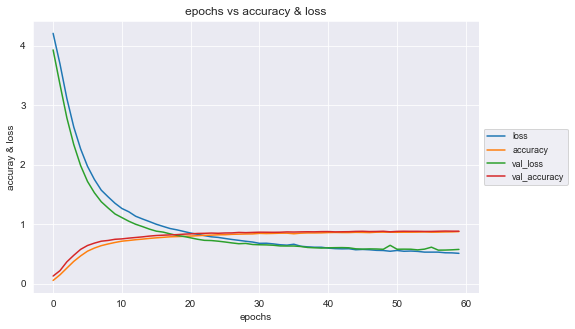

In [57]:
## plotting
## ======================================================

pd.DataFrame(history_rnn_2).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8.9);

In [58]:
train_acc = rnn_2.evaluate(train_ds)
test_acc = rnn_2.evaluate(test_ds)

115/115 [==============================] - 1s 10ms/step - loss: 0.5619 - accuracy: 0.8798


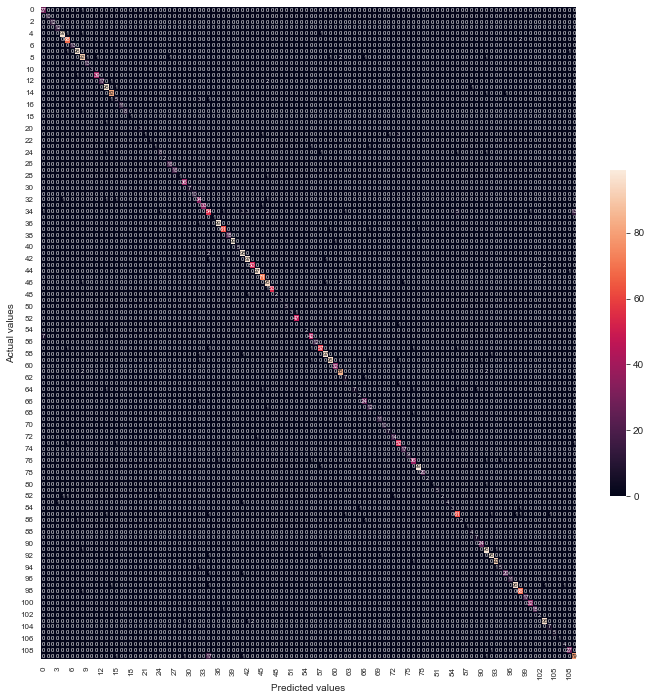

In [59]:
confusion = confusion_matrix(y_test, y_pred_test)

classes=labeler.classes_
cm = pd.DataFrame(confusion, range(len(jobs)), range(len(jobs)))

plt.figure(figsize = (12,12))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws  = {'size': 6},
             cbar_kws   = {'shrink': .5})
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

### 8.2.3 RNN 3 (Class Weigth)

In [60]:
max_ = train_df['job_category'].value_counts().max()
class_weight = {}
for i in range(len(index_category)):
    count = train_df[train_df['job_category'] == index_category[i]].shape[0]
    class_weight[i] = max_/count

class_weight

{0: 3.5398230088495577,
 1: 10.0,
 2: 8.695652173913043,
 3: 8.16326530612245,
 4: 1.0,
 5: 1.4234875444839858,
 6: 7.547169811320755,
 7: 1.0,
 8: 1.0,
 9: 7.6923076923076925,
 10: 40.0,
 11: 2.5316455696202533,
 12: 5.128205128205129,
 13: 1.0,
 14: 1.1976047904191616,
 15: 10.0,
 16: 9.090909090909092,
 17: 10.526315789473685,
 18: 100.0,
 19: 66.66666666666667,
 20: 30.76923076923077,
 21: 17.391304347826086,
 22: 66.66666666666667,
 23: 36.36363636363637,
 24: 8.695652173913043,
 25: 44.44444444444444,
 26: 6.25,
 27: 6.0606060606060606,
 28: 50.0,
 29: 2.7586206896551726,
 30: 14.814814814814815,
 31: 10.526315789473685,
 32: 2.6315789473684212,
 33: 2.962962962962963,
 34: 1.1799410029498525,
 35: 100.0,
 36: 1.0,
 37: 1.5748031496062993,
 38: 5.47945205479452,
 39: 1.0,
 40: 21.05263157894737,
 41: 1.0,
 42: 1.0,
 43: 1.941747572815534,
 44: 1.0230179028132993,
 45: 1.3986013986013985,
 46: 1.0,
 47: 1.834862385321101,
 48: 33.333333333333336,
 49: 28.571428571428573,
 50: 20.0

In [61]:
## Model Definition
## ======================================================

rnn_3 = Sequential([
    Embedding(input_dim                  = X_train_vocab_size, 
                  output_dim             = embedding_dim,
                  embeddings_initializer = Constant(embedding_matrix),
                  trainable              = False,
                  ),
    GRU(16, return_sequences=True),
    GRU(16),
    Dropout(0.2),
    Dense(len(jobs), activation='softmax')
])
rnn_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          511150    
                                                                 
 gru (GRU)                   (None, None, 16)          3264      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 110)               1870      
                                                                 
Total params: 517,916
Trainable params: 6,766
Non-trainable params: 511,150
_________________________________________________________________


In [62]:
## model compiling
## ======================================================

rnn_3.compile(loss='sparse_categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [63]:
## Model Fit
## ======================================================

clear_session()
np.random.seed(42)
set_seed(42)

checkpoint_cb = ModelCheckpoint(path + 'rnn_3.h5', save_best_only=True)
history_rnn_3 = rnn_3.fit(train_ds, 
                  epochs=60,
                  validation_data=test_ds,
                  class_weight=class_weight,
                  callbacks=[checkpoint_cb])

# hisotry save 
np.save(path + 'history_rnn_3.npy', history_rnn_3.history)

Epoch 1/60
460/460 [==============================] - 15s 27ms/step - loss: 13.7928 - accuracy: 0.0409 - val_loss: 4.4571 - val_accuracy: 0.0911
Epoch 2/60
460/460 [==============================] - 12s 27ms/step - loss: 12.9613 - accuracy: 0.1130 - val_loss: 4.0959 - val_accuracy: 0.1757
Epoch 3/60
460/460 [==============================] - 13s 28ms/step - loss: 11.8759 - accuracy: 0.1716 - val_loss: 3.7127 - val_accuracy: 0.2382
Epoch 4/60
460/460 [==============================] - 13s 28ms/step - loss: 10.9061 - accuracy: 0.2198 - val_loss: 3.3986 - val_accuracy: 0.2790
Epoch 5/60
460/460 [==============================] - 13s 27ms/step - loss: 10.1392 - accuracy: 0.2492 - val_loss: 3.2207 - val_accuracy: 0.3296
Epoch 6/60
460/460 [==============================] - 12s 26ms/step - loss: 9.5173 - accuracy: 0.2868 - val_loss: 3.0600 - val_accuracy: 0.3508
Epoch 7/60
460/460 [==============================] - 12s 27ms/step - loss: 8.9930 - accuracy: 0.3130 - val_loss: 2.8996 - val_accu

In [64]:
## model load
## ======================================================

rnn_3       = load_model(path + 'rnn_3.h5')
history_rnn_3 = np.load(path + 'history_rnn_3.npy', allow_pickle='TRUE').item()

In [65]:
train_acc = rnn_3.evaluate(train_ds)
test_acc = rnn_3.evaluate(test_ds)

115/115 [==============================] - 1s 11ms/step - loss: 1.0231 - accuracy: 0.7775


In [66]:
y_pred_test = np.argmax(rnn_3.predict(tf.ragged.constant(X_test_num)), axis=1)
np.array(labeler.classes_)[y_pred_test]

array(['Asociados', 'Asesores financieros y en inversiones',
       'Empleados de logística y transporte de pasajeros y mercancías',
       ..., 'Técnicos de recursos humanos', 'Estudiantes de doctorado',
       'Directores de departamentos administrativos'], dtype=object)

In [67]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
rnn_3_report = classification_report(y_test, y_pred_test, target_names=labeler.classes_, output_dict=True)
rnn_3_report_df= pd.DataFrame(rnn_3_report) \
    .transpose() \
    .round(3)

rnn_3_report_df

,precision,recall,f1-score,support
Administradores de sistemas,0.895,0.607,0.723,28.000
Agentes Inmobiliarios,0.769,1.000,0.870,10.000
Agentes y representantes comerciales,1.000,1.000,1.000,12.000
Analistas,0.429,1.000,0.600,12.000
Analistas de gestión y organización,0.899,0.980,0.938,100.000
Analistas digitales,0.656,0.600,0.627,70.000
Analistas financieros,0.929,1.000,0.963,13.000
Analistas y diseñadores de software,0.833,0.750,0.789,100.000
"Analistas, programadores y diseñadores Web y multimedia",0.827,0.670,0.740,100.000
"Arquitectos, urbanistas e ingenieros geógrafos",0.812,1.000,0.897,13.000


## 9. Final Model

In [68]:
final_categories = rnn_report_df[rnn_report_df['f1-score']>=0.8].index.tolist()
final_categories = final_categories[0:-3]

print(f'Número de categorías a tener en cuenta: {len(final_categories)}')

Número de categorías a tener en cuenta: 94


In [69]:
final_categories[0:10]

['Administradores de sistemas',
 'Agentes Inmobiliarios',
 'Agentes y representantes comerciales',
 'Analistas',
 'Analistas de gestión y organización',
 'Analistas digitales',
 'Analistas financieros',
 'Analistas y diseñadores de software',
 'Analistas, programadores y diseñadores Web y multimedia',
 'Arquitectos, urbanistas e ingenieros geógrafos']

In [70]:
train_final_df = train_df[train_df['job_category'].isin(final_categories)]
test_final_df = test_df[test_df['job_category'].isin(final_categories)]

In [71]:
## from token to numbers train dataset
## =============================================================================

X_train_final_num = tokenizer.texts_to_sequences(train_final_df['job_description_short'])
X_test_final_num =  tokenizer.texts_to_sequences(test_final_df['job_description_short'])

y_train_final = labeler.transform(train_final_df['job_category'])
y_test_final = labeler.transform(test_final_df['job_category'])

In [72]:
## train/test dataset
## =============================================================================

BATCH_SIZE = 32
train_final_ds = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(X_train_final_num), y_train_final)).batch(BATCH_SIZE)
test_final_ds = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(X_test_final_num), y_test_final)).batch(BATCH_SIZE)

## RNN Final

In [73]:
## Model Architecture
## ======================================================

rnn_4 = Sequential([
    Embedding(input_dim=X_train_vocab_size, 
                  output_dim=embedding_dim,
                  embeddings_initializer=Constant(embedding_matrix),
                  trainable=False,
                  ),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.2),
    Dense(len(jobs), activation='softmax')
])

In [74]:
## Model Compiling
## ======================================================

rnn_4.compile(loss='sparse_categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [75]:
## Model Fit
## ======================================================

clear_session()
np.random.seed(42)
set_seed(42)

checkpoint_cb = ModelCheckpoint(path + 'rnn_4.h5', save_best_only=True)
history_rnn_4 = rnn_4.fit(train_final_ds, 
                  epochs=60,
                  validation_data=test_final_ds,
                  callbacks=[checkpoint_cb])

# save history
np.save(path + 'history_rnn_4.npy', history_rnn_4.history)

Epoch 1/60
440/440 [==============================] - 16s 31ms/step - loss: 2.9413 - accuracy: 0.3395 - val_loss: 1.8799 - val_accuracy: 0.5652
Epoch 2/60
440/440 [==============================] - 13s 29ms/step - loss: 1.6607 - accuracy: 0.6096 - val_loss: 1.1875 - val_accuracy: 0.7309
Epoch 3/60
440/440 [==============================] - 12s 28ms/step - loss: 1.0802 - accuracy: 0.7550 - val_loss: 0.8222 - val_accuracy: 0.8153
Epoch 4/60
440/440 [==============================] - 12s 28ms/step - loss: 0.7646 - accuracy: 0.8318 - val_loss: 0.6185 - val_accuracy: 0.8687
Epoch 5/60
440/440 [==============================] - 12s 28ms/step - loss: 0.5708 - accuracy: 0.8698 - val_loss: 0.4847 - val_accuracy: 0.8954
Epoch 6/60
440/440 [==============================] - 13s 30ms/step - loss: 0.4310 - accuracy: 0.9023 - val_loss: 0.3779 - val_accuracy: 0.9150
Epoch 7/60
440/440 [==============================] - 13s 29ms/step - loss: 0.3308 - accuracy: 0.9248 - val_loss: 0.3150 - val_accuracy:

In [76]:
## model load
## ======================================================

rnn_4       = load_model(path + 'rnn_4.h5')
history_rnn_4 = np.load(path + 'history_rnn_4.npy', allow_pickle='TRUE').item()

In [77]:
train_acc = rnn_4.evaluate(train_final_ds)
test_acc = rnn_4.evaluate(test_final_ds)

110/110 [==============================] - 1s 11ms/step - loss: 0.1571 - accuracy: 0.9676


In [78]:
y_pred_test = np.argmax(rnn_4.predict(tf.ragged.constant(X_test_final_num)), axis=1)
np.array(labeler.classes_)[y_pred_test]

array(['Asociados', 'Asesores financieros y en inversiones', 'Managers',
       ..., 'Técnicos de recursos humanos', 'Investigadores',
       'Directores de departamentos administrativos'], dtype=object)

In [79]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
rnn_4_report = classification_report(y_test_final, y_pred_test, target_names=final_categories, output_dict=True)
rnn_4_report_df= pd.DataFrame(rnn_4_report) \
    .transpose() \
    .round(3)

rnn_4_report_df

,precision,recall,f1-score,support
Administradores de sistemas,0.844,0.964,0.900,28.000
Agentes Inmobiliarios,1.000,1.000,1.000,10.000
Agentes y representantes comerciales,1.000,1.000,1.000,12.000
Analistas,1.000,1.000,1.000,12.000
Analistas de gestión y organización,0.971,0.990,0.980,100.000
Analistas digitales,0.986,0.971,0.978,70.000
Analistas financieros,1.000,1.000,1.000,13.000
Analistas y diseñadores de software,0.990,0.990,0.990,100.000
"Analistas, programadores y diseñadores Web y multimedia",0.891,0.900,0.896,100.000
"Arquitectos, urbanistas e ingenieros geógrafos",1.000,1.000,1.000,13.000


In [80]:
## Exporting word_index for further application .json
## =============================================================================

with open('database/final_categories.json', 'w',  encoding='utf-8') as f:
    json.dump(word_index, f, ensure_ascii=False, indent=4)

## 9. Conclusions